In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   139M      0  0:00:05  0:00:05 --:--:--  145M


In [5]:
!unzip -q kagglecatsanddogs_3367a.zip

In [5]:
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [7]:
!cat readme\[1\].txt


For information see http://research.microsoft.com/en-us/projects/asirra/corpus.aspx

Contact: jelson


In [6]:
import os
folder_path = os.path.join("PetImages","Cat")
fpath = os.path.join(folder_path,"0.jpg")
fobj=open(fpath,'rb')

In [21]:
fobj.peek(10)


b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x00\x01\x04\x05\x06\x07\xff\xc4\x006\x10\x00\x02\x02\x01\x03\x03\x02\x04\x05\x04\x02\x02\x02\x03\x00\x00\x00\x01\x02\x11\x03\x04\x12!\x051AQa\x06\x13"q\x142R\x81\x91\x15B\xa1\xb1#b\x82\x92\x07\xc14r\xd1\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00$\x11\x01\x01\x00\x02\x02\x02\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x01\x02\x11\x03!\x121\x04\x132AQ"B\x14q\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x

In [7]:
import os
num_skipped = 0
for folder_name in ("Cat","Dog"):
  folder_path = os.path.join("PetImages",folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path,fname)
    try:
      fobj = open(fpath,'rb')
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [8]:
image_size = (180,180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset ="validation",
    seed = 1337,
    image_size = image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


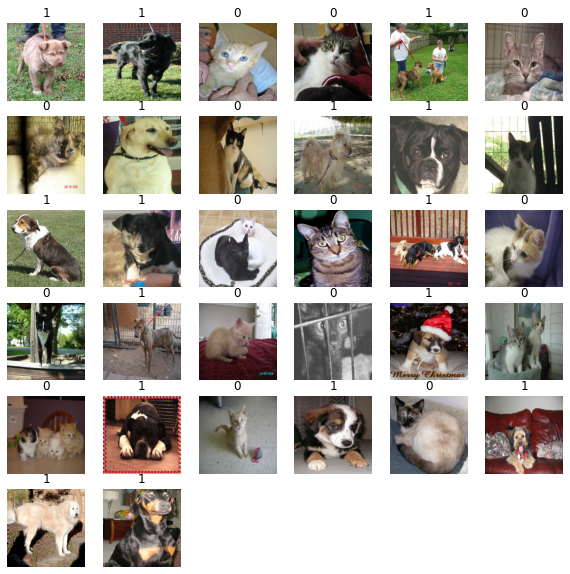

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(32):
    ax =plt.subplot(6,6,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")


In [10]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
    ]
)

[link text](https://)

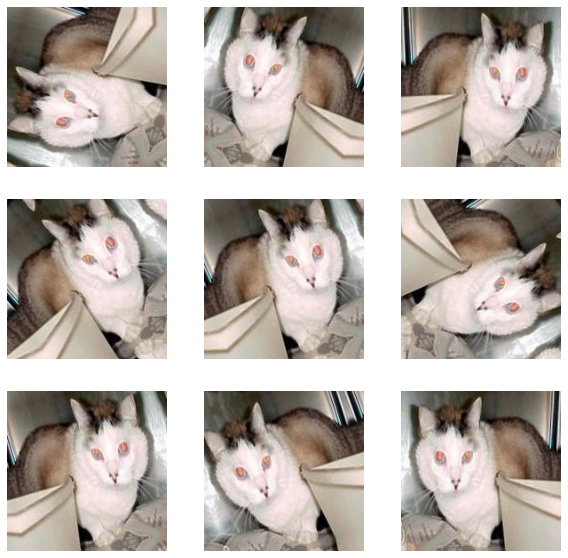

In [42]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax=plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[31].numpy().astype("uint8"))
    
    plt.axis("off")



In [12]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size = 32)

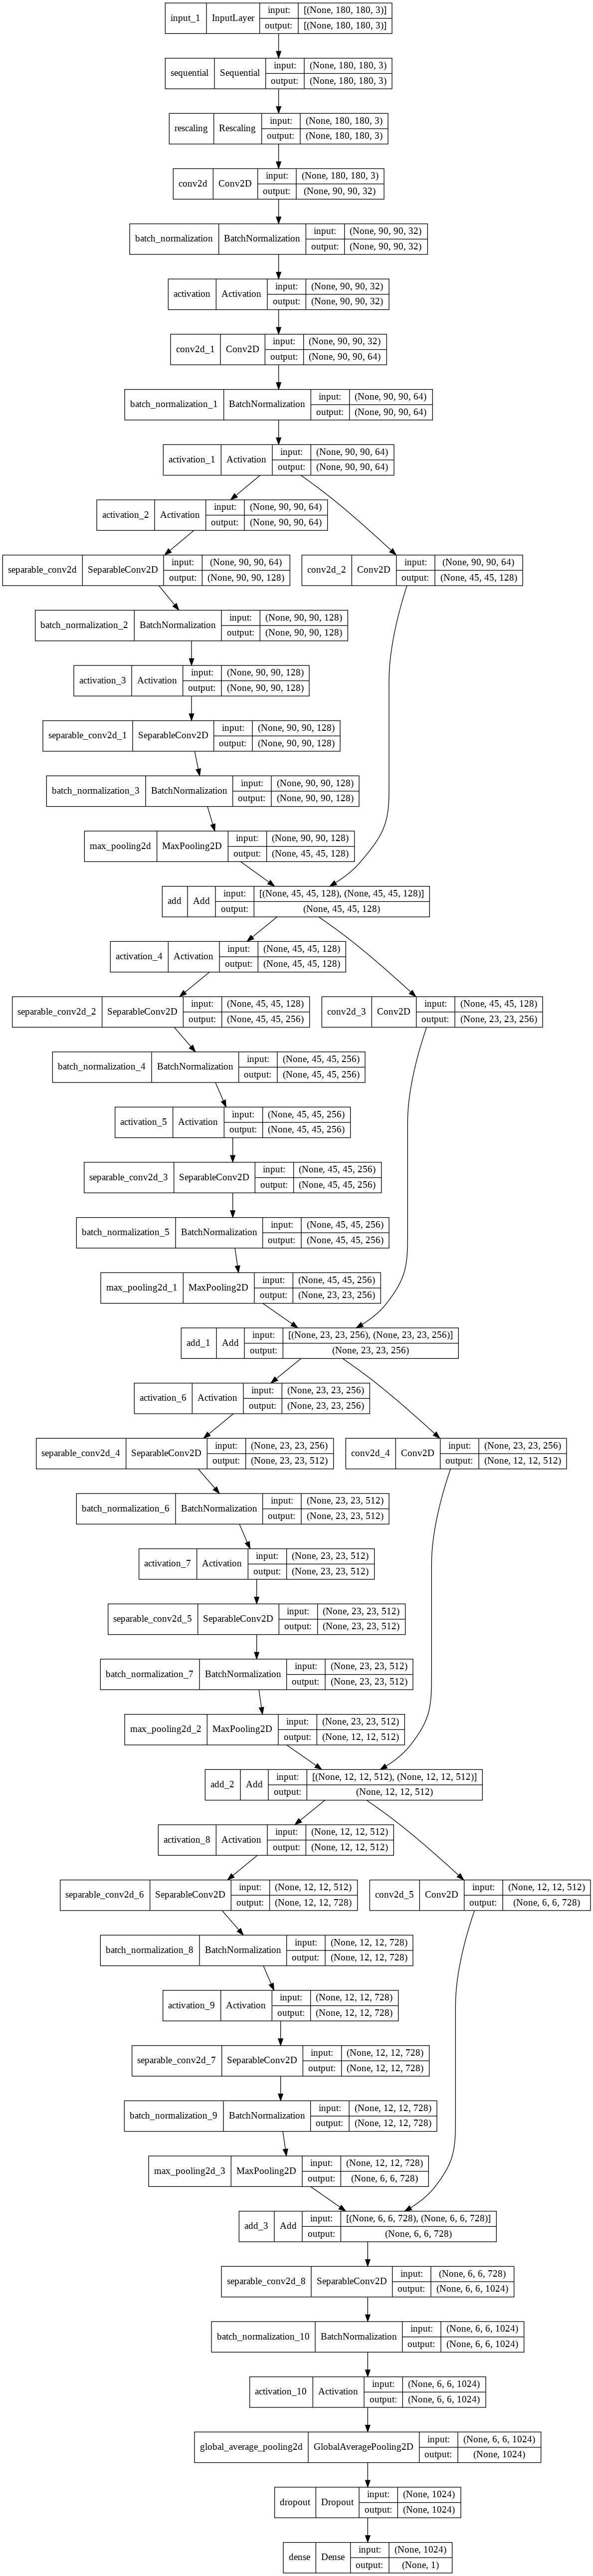

In [11]:
def make_model(input_shape,num_classes):
  inputs = keras.Input(shape = input_shape)
  x=data_augmentation(inputs)

  x=layers.Rescaling(1.0/255)(x)
  x=layers.Conv2D(32,3,strides=2,padding="same")(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)

  x=layers.Conv2D(64,3,padding = "same")(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)

  previous_block_activation = x #set aside residual

  for size in [128, 256, 512,728]:
    x=layers.Activation("relu")(x)
    x=layers.SeparableConv2D(size,3,padding = "same")(x)
    x=layers.BatchNormalization()(x)

    x=layers.Activation("relu")(x)
    x=layers.SeparableConv2D(size,3,padding = "same")(x)
    x=layers.BatchNormalization()(x)

    x=layers.MaxPooling2D(3,strides=2,padding="same")(x)
    residual = layers.Conv2D(size,1,strides=2,padding="same")(previous_block_activation)

    x= layers.add([x,residual])
    previous_block_activation=x

  x=layers.SeparableConv2D(1024,3,padding="same")(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)

  x=layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units=1
  else:
    activation =="softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs=layers.Dense(units,activation=activation)(x)
  return keras.Model(inputs,outputs)

model=make_model(input_shape=image_size + (3,),num_classes=2)
keras.utils.plot_model(model,show_shapes=True)

In [13]:
#@title Default title text
epochs= 50
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.6632

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


586/586 [==============================] - 303s 494ms/step - loss: 0.6251 - accuracy: 0.6632 - val_loss: 0.5672 - val_accuracy: 0.7191
Epoch 2/50
586/586 [==============================] - 288s 492ms/step - loss: 0.5001 - accuracy: 0.7593 - val_loss: 0.4836 - val_accuracy: 0.7760
Epoch 3/50
586/586 [==============================] - 288s 491ms/step - loss: 0.4262 - accuracy: 0.8057 - val_loss: 0.3785 - val_accuracy: 0.8291
Epoch 4/50
586/586 [==============================] - 288s 491ms/step - loss: 0.3735 - accuracy: 0.8339 - val_loss: 0.4184 - val_accuracy: 0.7997
Epoch 5/50
586/586 [==============================] - 288s 491ms/step - loss: 0.3371 - accuracy: 0.8571 - val_loss: 0.3002 - val_accuracy: 0.8708
Epoch 6/50
586/586 [==============================] - 288s 491ms/step - loss: 0.3015 - accuracy: 0.8697 - val_loss: 0.2613 - val_accuracy: 0.8917
Epoch 7/50
586/586 [==============================] - 289s 492ms/step - loss: 0.2645 - accuracy: 0.8893 - val_loss: 0.5837 - val_accura

KeyboardInterrupt: ignored

In [19]:
img=keras.preprocessing.image.load_img("PetImages/Cat/6779.jpg",target_size=image_size)

img_array=keras.preprocessing.image.img_to_array(img)
img_array=tf.expand_dims(img_array,0)

model2= keras.models.load_model('save_at_6.h5')
predictions = model2.predict(img_array)

score = predictions[0]
print("This image is %.2f percent cat and %.2f percent dog." % (100*(1-score),100*score))

This image is 48.52 percent cat and 51.48 percent dog.


(-0.5, 179.5, 179.5, -0.5)

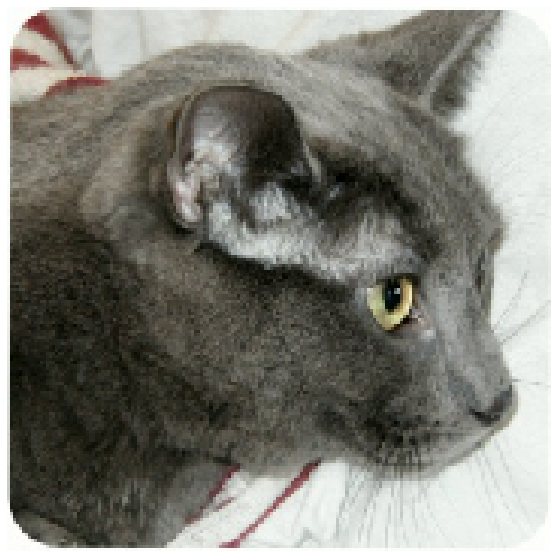

In [17]:
plt.figure(figsize=(10,10))

plt.imshow(img)
    
plt.axis("off")